# Analyzing NYC High School Data

The SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets.

Below are the dataframes to be cleaned and merged:

- SAT scores by school - SAT scores for each high school in New York City
- School attendance - Attendance information for each school in New York City
- Class size - Information on class size for each school
- AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- Graduation outcomes - The percentage of students who graduated, and other outcome information
- Demographics - Demographic information for each school
- School survey - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

In [4]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d


In [7]:
#Read in the surveys
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey

In [9]:
# Add DBN column in class_size
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

In [11]:
#Convert columns to numeric

cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Extract latitude and longitude
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

In [13]:
# Condense datasets

class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

In [14]:
# Convert AP scores to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

In [15]:
# Combine datasets
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

In [16]:
# Add school district column for mapping
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

In [24]:
# Find correlations
correlations = combined.corr()
correlations = correlations["sat_score"]

#Statistically significant correlations
mask = (correlations > 0.35) | (correlations < -0.35)
top_correlations = correlations[mask]

print(top_correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_percent                            -0.398750
sped_percent                           -0.448170
asian_num                               0.475445
asian_per                               0.570730
hispanic_per                           -0.396985
white_num                               0.449559
white_per                               0.620718
female_num                              0.388631
N_s                 

# Survey Analysis

In [28]:
survey_fields.remove('DBN')

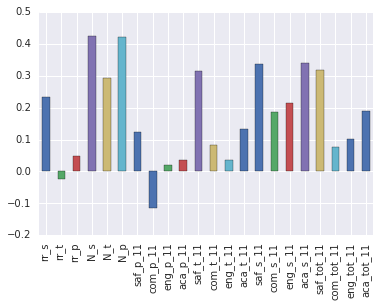

In [31]:
combined.corr()['sat_score'][survey_fields].plot.bar()

Observations:
- There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

- It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

- How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

- The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

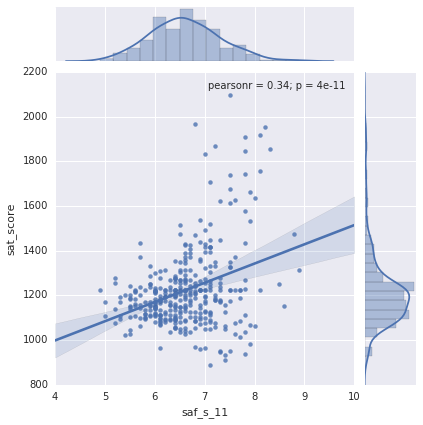

In [38]:
# Analysis safety vs sat_score
sns.jointplot(x="saf_s_11", y="sat_score", data=combined,
                  kind="reg", truncate=False, 
              xlim=(4,10), ylim=(800,2200))

In [43]:
# Safety score for each borough
combined.groupby('boro').agg(np.mean)[['sat_score','saf_s_11']]

,sat_score,saf_s_11
boro,,
Bronx,1157.598203,6.606577
Brooklyn,1181.364461,6.370755
Manhattan,1278.331410,6.831370
Queens,1286.753032,6.721875
Staten Island,1382.500000,6.530000


Observations:
    - There is a positive correlation between the perceived safety and the sat scores however looking at the plot we observe this relationship is weaker than expected.
    - Manhattan and Queens leading the perceived safety score among the boroughs.

# Race Analysis

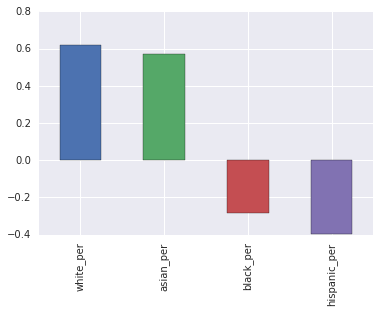

In [45]:
# Correlation between race and SAT score
race_fields = ['white_per','asian_per','black_per','hispanic_per']

combined.corr()['sat_score'][race_fields].plot.bar()

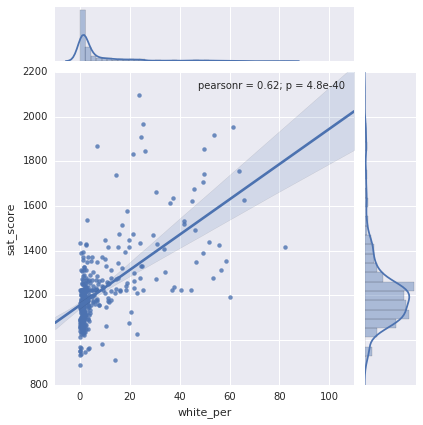

In [47]:
# Analysis white percentage vs sat_score
sns.jointplot(x="white_per", y="sat_score", data=combined,
                  kind="reg", truncate=False, 
              xlim=(-10,110), ylim=(800,2200))

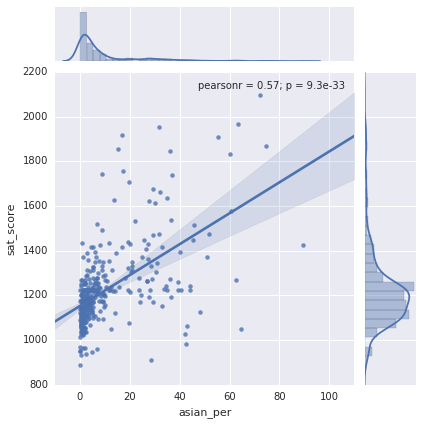

In [48]:
# Analysis asian percentage vs sat_score
sns.jointplot(x="asian_per", y="sat_score", data=combined,
                  kind="reg", truncate=False, 
              xlim=(-10,110), ylim=(800,2200))

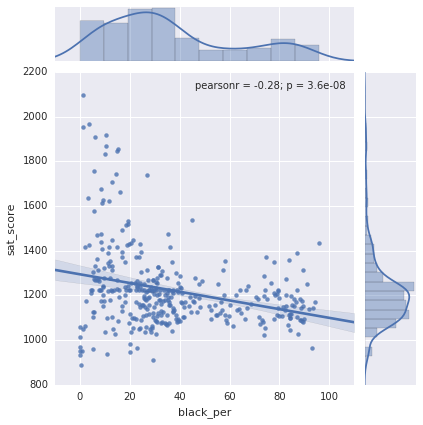

In [49]:
# Analysis black percentage vs sat_score
sns.jointplot(x="black_per", y="sat_score", data=combined,
                  kind="reg", truncate=False, 
              xlim=(-10,110), ylim=(800,2200))

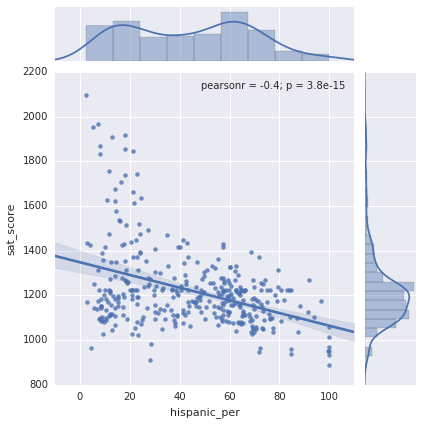

In [51]:
# Analysis hispanic percentage vs sat_score
sns.jointplot(x="hispanic_per", y="sat_score", data=combined,
                  kind="reg", truncate=False, 
              xlim=(-10,110), ylim=(800,2200))

In [61]:
# School with hispanic percentage > 95%
hispa_hs = combined[combined['hispanic_per'] > 95]
hispa_hs[['SCHOOL NAME','sat_score','boro']]

,SCHOOL NAME,sat_score,boro
44,MANHATTAN BRIDGES HIGH SCHOOL,1058.0,Manhattan
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0,Manhattan
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0,Manhattan
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0,Bronx
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,Bronx
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0,Bronx
253,MULTICULTURAL HIGH SCHOOL,887.0,Brooklyn
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0,Queens


Observation:
    - The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [60]:
# School with hispanic percentage < 10% & sat_score > 1800
mask = (combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)
combined[mask][['SCHOOL NAME','sat_score','boro']]

,SCHOOL NAME,sat_score,boro
37,STUYVESANT HIGH SCHOOL,2096.0,Manhattan
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,Bronx
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,Brooklyn
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0,Queens
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,Staten Island


Observation: 
    - Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

# Gender Analysis

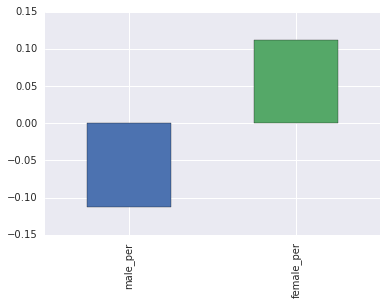

In [64]:
# Correlation between gender and SAT score
combined.corr()['sat_score'][['male_per','female_per']].plot.bar()

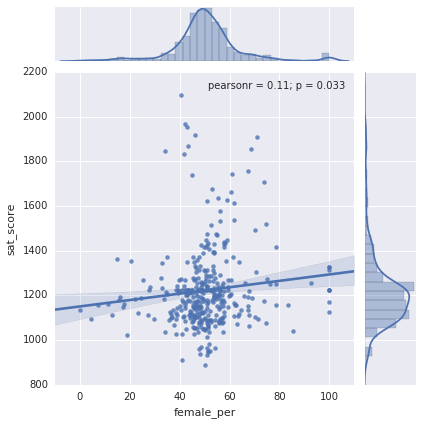

In [65]:
# Analysis female percentage vs sat_score
sns.jointplot(x="female_per", y="sat_score", data=combined,
                  kind="reg", truncate=False, 
              xlim=(-10,110), ylim=(800,2200))

In [67]:
# School with female percentage < 60% & sat_score > 1700
mask = (combined['female_per'] > 60) & (combined['sat_score'] > 1700)
combined[mask][['SCHOOL NAME','sat_score','boro']]

,SCHOOL NAME,sat_score,boro
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,Manhattan
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,Manhattan
60,BEACON HIGH SCHOOL,1744.0,Manhattan
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,Manhattan
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0,Queens


Observations:
- In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

- Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

- These schools appears to be very selective liberal arts schools that have high academic standards.

# Advanced Placement (AP) Analysis 

In [71]:
# Percentage of students per class that took the AP exam
combined['ap_per'] = (combined['AP Test Takers ']/combined['total_enrollment'])*100

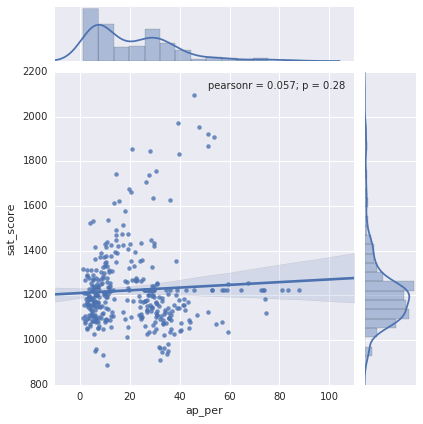

In [73]:
# Analysis female percentage vs sat_score
sns.jointplot(x="ap_per", y="sat_score", data=combined,
                  kind="reg", truncate=False, 
              xlim=(-10,110), ylim=(800,2200))

Observations:
    - There is not a meaningfull correlation between the AP takers percentage and the average SAT exam.
    - There is a small cluster with ap_per > 60% and SAT > 1800 that is relevant to investigate

# Class size analysis

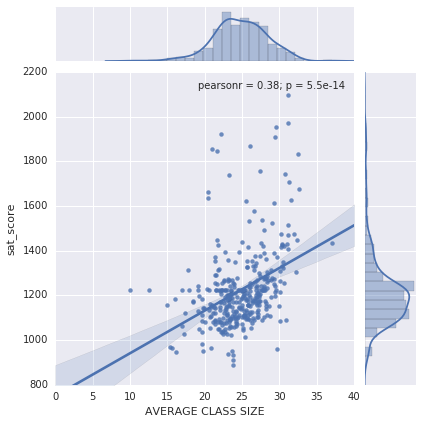

In [78]:
#

# Analysis female percentage vs sat_score
sns.jointplot(x="AVERAGE CLASS SIZE", y="sat_score", data=combined,
                  kind="reg", truncate=False, 
              xlim=(0,40), ylim=(800,2200))


In [83]:
# School with class size < 17
mask = (combined['AVERAGE CLASS SIZE'] < 17)
combined[mask][['SCHOOL NAME','sat_score','boro']]

,SCHOOL NAME,sat_score,boro
6,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,1182.000000,Manhattan
8,ESSEX STREET ACADEMY,1156.000000,Manhattan
56,THE URBAN ASSEMBLY SCHOOL FOR GREEN CAREERS,1223.438806,Manhattan
91,INTERNATIONAL COMMUNITY HIGH SCHOOL,945.000000,Bronx
126,BRONX INTERNATIONAL HIGH SCHOOL,965.000000,Bronx
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.000000,Bronx
264,THE URBAN ASSEMBLY SCHOOL FOR CRIMINAL JUSTICE,1223.438806,Brooklyn


In [86]:
# School with class size > 30 & sat_score > 1600
mask = (combined['AVERAGE CLASS SIZE'] > 30) & (combined['sat_score'] > 1600)
combined[mask][['SCHOOL NAME','sat_score','boro']]

,SCHOOL NAME,sat_score,boro
24,N.Y.C. LAB SCHOOL FOR COLLABORATIVE STUDIES,1677.0,Manhattan
37,STUYVESANT HIGH SCHOOL,2096.0,Manhattan
60,BEACON HIGH SCHOOL,1744.0,Manhattan
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,Manhattan
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,Bronx
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,Brooklyn
278,LEON M. GOLDSTEIN HIGH SCHOOL FOR THE SCIENCES,1627.0,Brooklyn


Observations:
    - There is a positive correlation between the class size and the SAT scores, however the underlyting factor are not obvious.
    
    - School with small size classes are dedicated to special needs (e.g. sign language) or communities (e.g. inmigrants arrived to the USA), hence it makes sense that the SAT scores is lower.
    
    - School with higher size classes are typically HS with high standards with high demand, hence the ocupation is maximized.

# Neighborhoods Analysis

In [87]:
# Safety score for each borough
combined.groupby('boro').agg(np.mean)[['sat_score','saf_s_11']]

,sat_score,saf_s_11
boro,,
Bronx,1157.598203,6.606577
Brooklyn,1181.364461,6.370755
Manhattan,1278.331410,6.831370
Queens,1286.753032,6.721875
Staten Island,1382.500000,6.530000


In [93]:
# Top 5 high school per borough
top_hs = {}
boros=['Bronx','Brooklyn','Manhattan','Queens','Staten Island']

for b in boros:
    top5 = combined[combined['boro']==b].sort_values(by='sat_score',
                                               ascending=False).head(5)
    top_hs[b]=top5

top_hs['Brooklyn']



,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.000000,3692.000000,...,0,0,0,0,0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13,39.703676
198,14K449,"BROOKLYN LATIN SCHOOL, THE",72,586.0,584.0,570.0,1740.0,0,129.028846,197.038462,...,0,0,0,0,0,"223 Graham Avenue\nBrooklyn, NY 11206\n(40.709...",40.709900,-73.943660,14,27.570266
278,22K535,LEON M. GOLDSTEIN HIGH SCHOOL FOR THE SCIENCES,259,524.0,561.0,542.0,1627.0,LEON GOLDSTEIN HS SCIENCES,367.000000,575.000000,...,0,0,0,0,0,"1830 Shore Boulevard\nBrooklyn, NY 11235\n(40....",40.580847,-73.936089,22,35.909980
276,22K405,MIDWOOD HIGH SCHOOL,824,478.0,519.0,476.0,1473.0,MIDWOOD HS,745.000000,1223.000000,...,0,0,0,0,0,"2839 Bedford Avenue\nBrooklyn, NY 11210\n(40.6...",40.633335,-73.952916,22,19.390942
235,17K590,MEDGAR EVERS COLLEGE PREPARATORY SCHOOL,165,476.0,481.0,479.0,1436.0,MIDDLE COLL HS @ MEDGAR EVERS,272.000000,507.000000,...,0,0,0,0,0,"1186 Carroll Street\nBrooklyn, NY 11225\n(40.6...",40.667162,-73.950858,17,24.637681
